# LANL Earthquake prediction

2019/04/10

This is the very beginning of the challenge for LANL Earthquake prediction.
While downloading first look into data addtional information

![](./Capture1.JPG)

So data should be a mix of some periodic and aperiodic signals.

From the data description
### Data fields
acoustic_data - the seismic signal [int16]<br>
time_to_failure - the time (in seconds) until the next laboratory earthquake [float64]<br>
seg_id - the test segment ids for which predictions should be made (one prediction per segment)<br>
<br>
So it is one dimensional int16 input and continous output to predict.
Looks like a simple regression problem, just one dimensional, but from other source we know it is not that simple.

### Look into discussions

From host there is a introdution thread:
https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77525#latest-500808

They listed three papers of their research, which dealt with tha same data for this competition.
In their first paper: https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2017GL074677

From their abstract:
>  These predictions are based __solely on the instantaneous physical characteristics of the acousticalsignal and do not make use of its history__. Surprisingly, machine learning identifies a signal emitted from thefault zone previously thought to be low-amplitude noise that enables failure forecasting throughout thelaboratory quake cycle. We infer that this signal originates from continuous grain motions of the fault gougeas the fault blocks displace.

Their method:
![](./Capture3.JPG)

So they use a 1000-trees Random Forrest to predict the experimental failure.

2019/04/16

I was super busy and no time to process the data...From today I want to use more complicated library to process the data.
From the thread: https://www.kaggle.com/allunia/shaking-earth
We know that for this dataset training data is quite different from test data, as below.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
train1 = pd.read_csv('train.csv', nrows=300000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

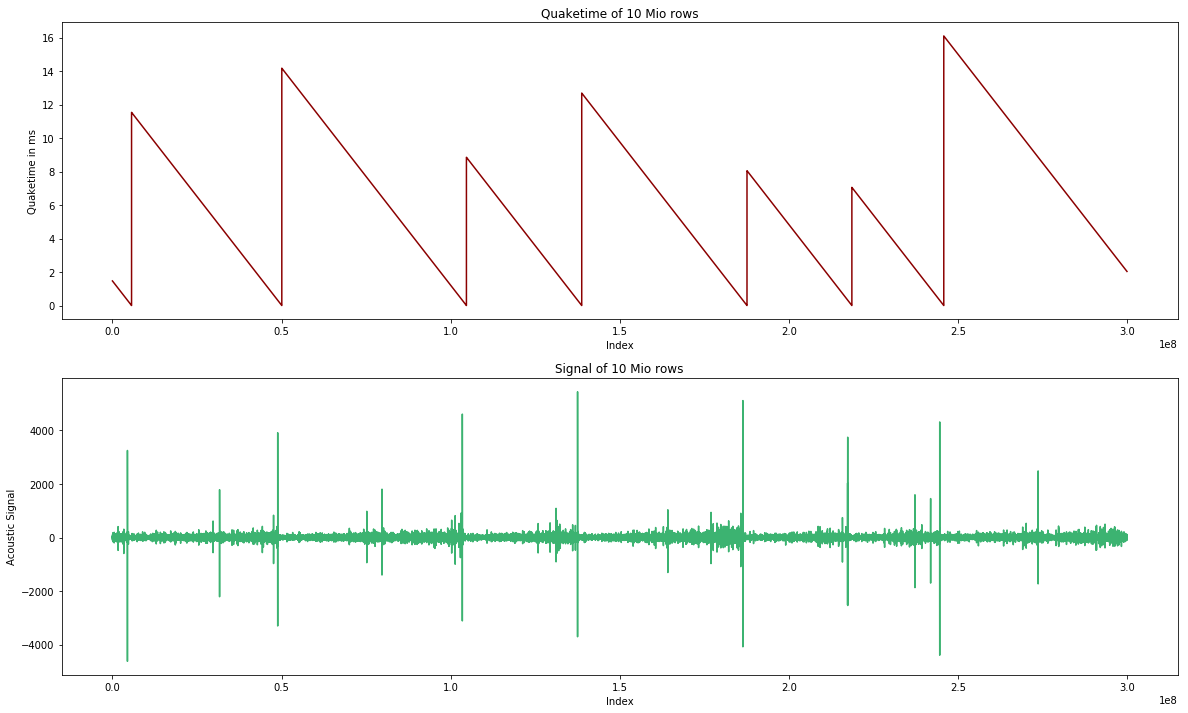

In [3]:
def plot_train_data_seg(dataset):
    ax[0].plot(dataset.index.values, dataset.time_to_failure.values, c="darkred")
    ax[0].set_title("Quaketime of 10 Mio rows")
    ax[0].set_xlabel("Index")
    ax[0].set_ylabel("Quaketime in ms");
    ax[1].plot(dataset.index.values, dataset.acoustic_data.values, c="mediumseagreen")
    ax[1].set_title("Signal of 10 Mio rows")
    ax[1].set_xlabel("Index")
    ax[1].set_ylabel("Acoustic Signal");
    
fig, ax = plt.subplots(2,1, figsize=(20,12))
plot_train_data_seg(train1)

#### We can see that experimental failure happened soon after the acoustic peak.
Also the peak will reach over -6000~6000
We can see the decreasing

In [13]:
test1 = pd.read_csv('test\seg_00a37e.csv', nrows=10000000, dtype={'acoustic_data': np.int16})
test2 = pd.read_csv('test\seg_00be11.csv', nrows=10000000, dtype={'acoustic_data': np.int16})
test3 = pd.read_csv('test\seg_00c35b.csv', nrows=10000000, dtype={'acoustic_data': np.int16})
test4 = pd.read_csv('test\seg_00cc91.csv', nrows=10000000, dtype={'acoustic_data': np.int16})
test5 = pd.read_csv('test\seg_00e5f7.csv', nrows=10000000, dtype={'acoustic_data': np.int16})
test6 = pd.read_csv('test\seg_00f3b9.csv', nrows=10000000, dtype={'acoustic_data': np.int16})

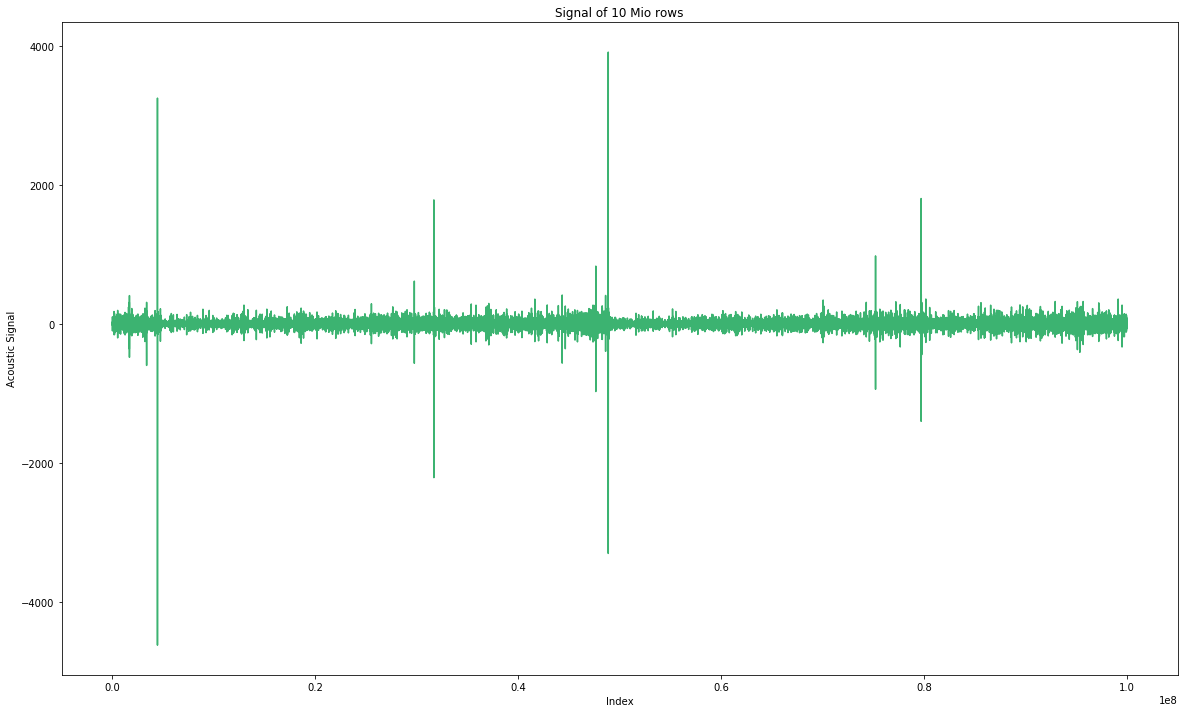

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20,12))

def plot_data_seg(dataset):
    ax.plot(dataset.index.values, dataset.acoustic_data.values, c="mediumseagreen")
    ax.set_title("Signal of 10 Mio rows")
    ax.set_xlabel("Index")
    ax.set_ylabel("Acoustic Signal");

plot_data_seg(train1)

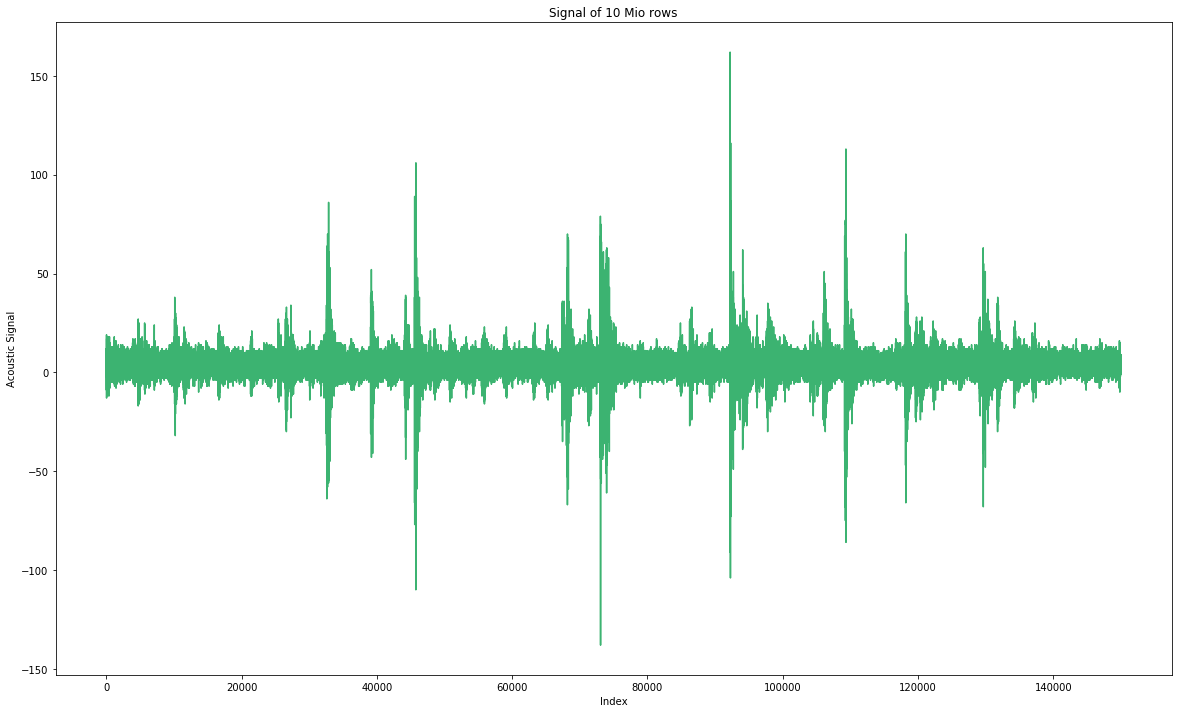

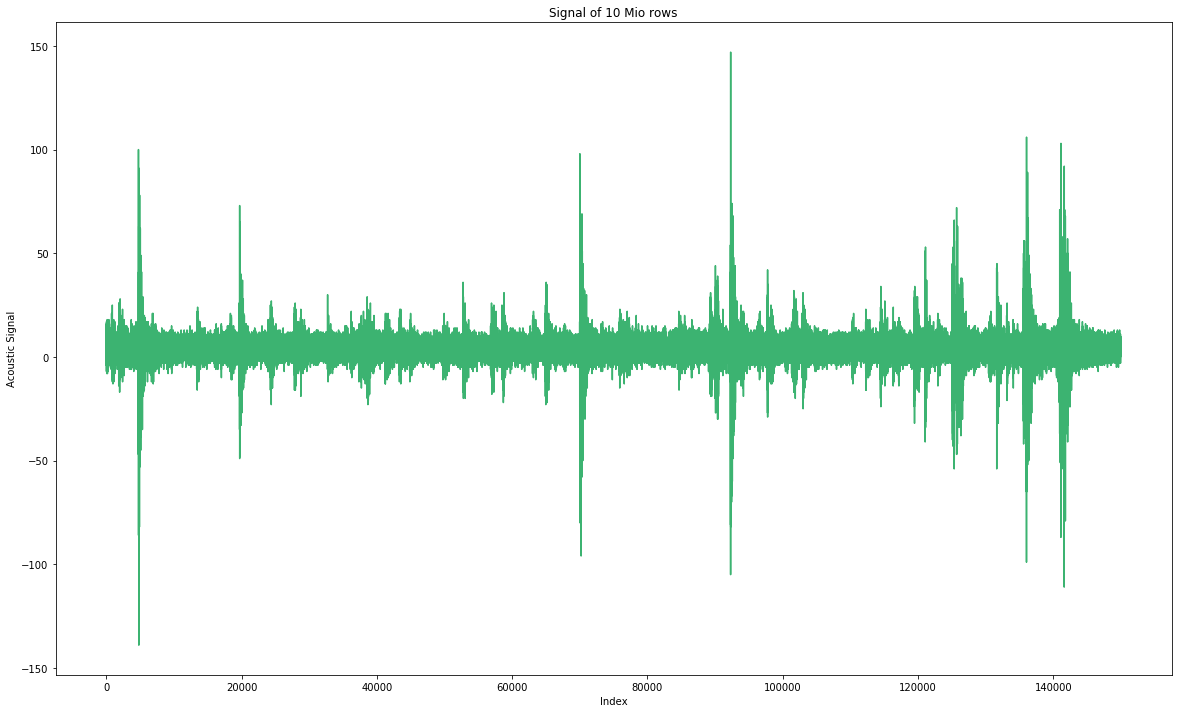

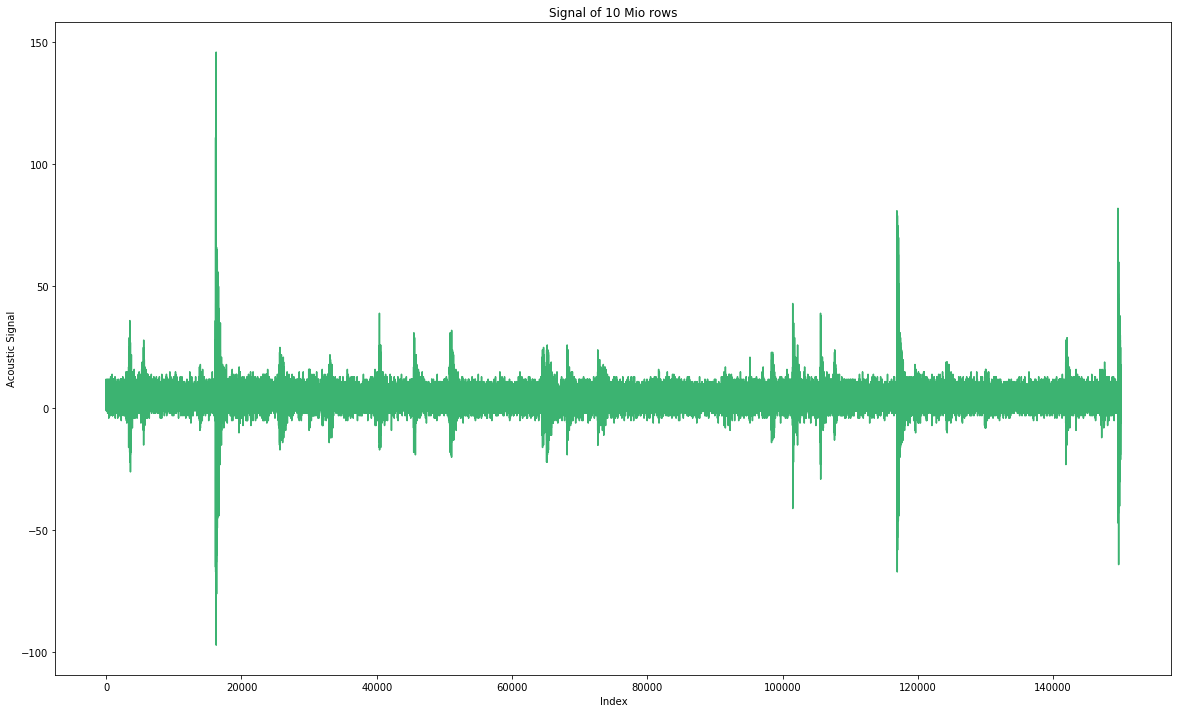

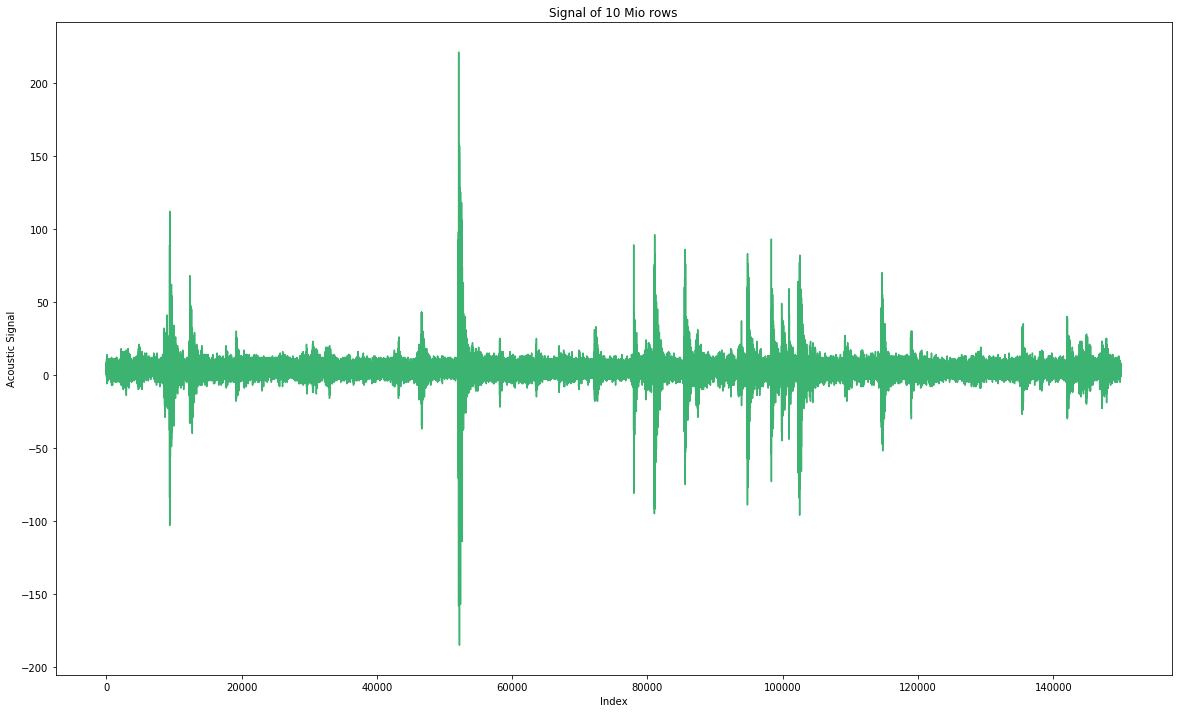

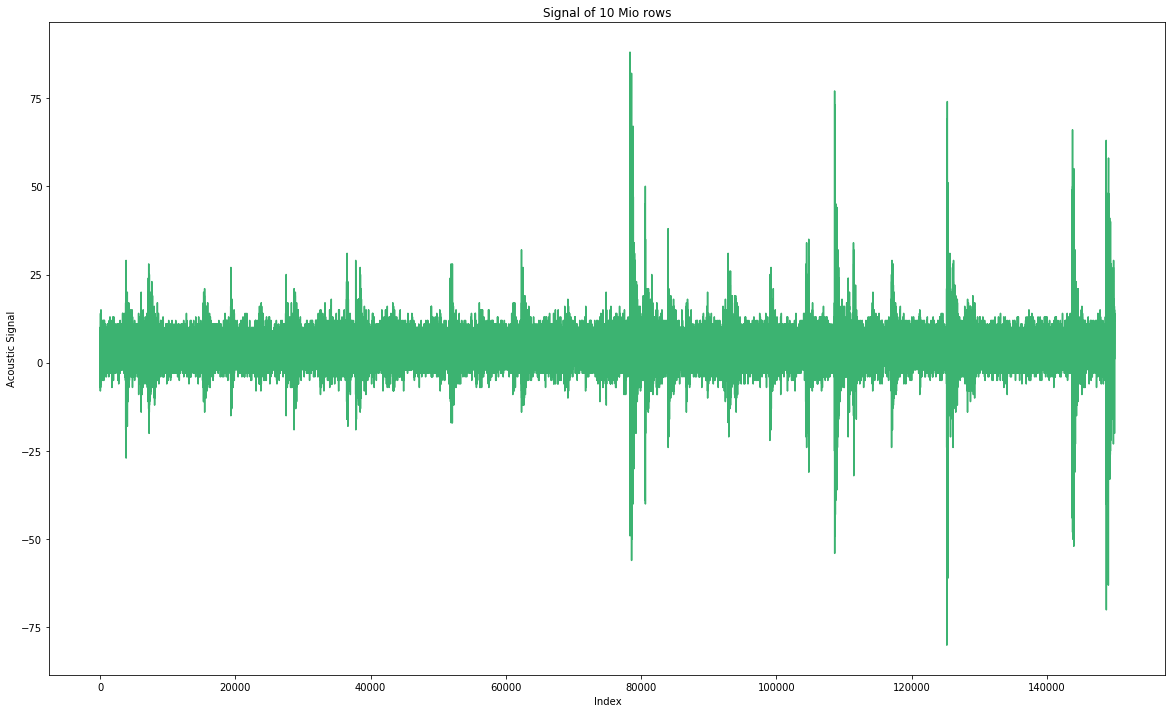

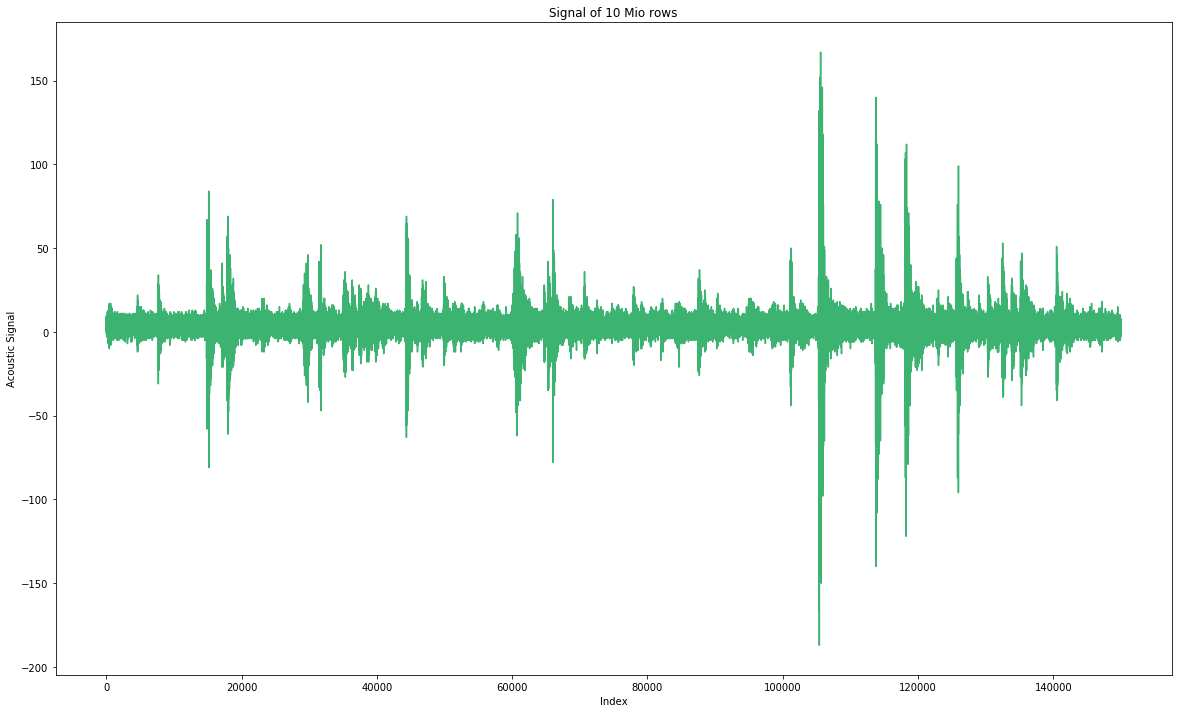

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20,12))
plot_data_seg(test1)
fig, ax = plt.subplots(1, 1, figsize=(20,12))
plot_data_seg(test2)
fig, ax = plt.subplots(1, 1, figsize=(20,12))
plot_data_seg(test3)
fig, ax = plt.subplots(1, 1, figsize=(20,12))
plot_data_seg(test4)
fig, ax = plt.subplots(1, 1, figsize=(20,12))
plot_data_seg(test5)
fig, ax = plt.subplots(1, 1, figsize=(20,12))
plot_data_seg(test6)


For these segments they seemed to be a little bit different from train data.
The maximum only reaches less than 250. So not for sure if there is a experimental failure or not.
Is this for true for all test data?

In [29]:
test_segs = [pd.read_csv(os.path.join('test', filename), nrows=10000000, dtype={'acoustic_data': np.int16}) for filename in os.listdir('test')]

In [36]:
segs = [seg.max().acoustic_data for seg in test_segs]

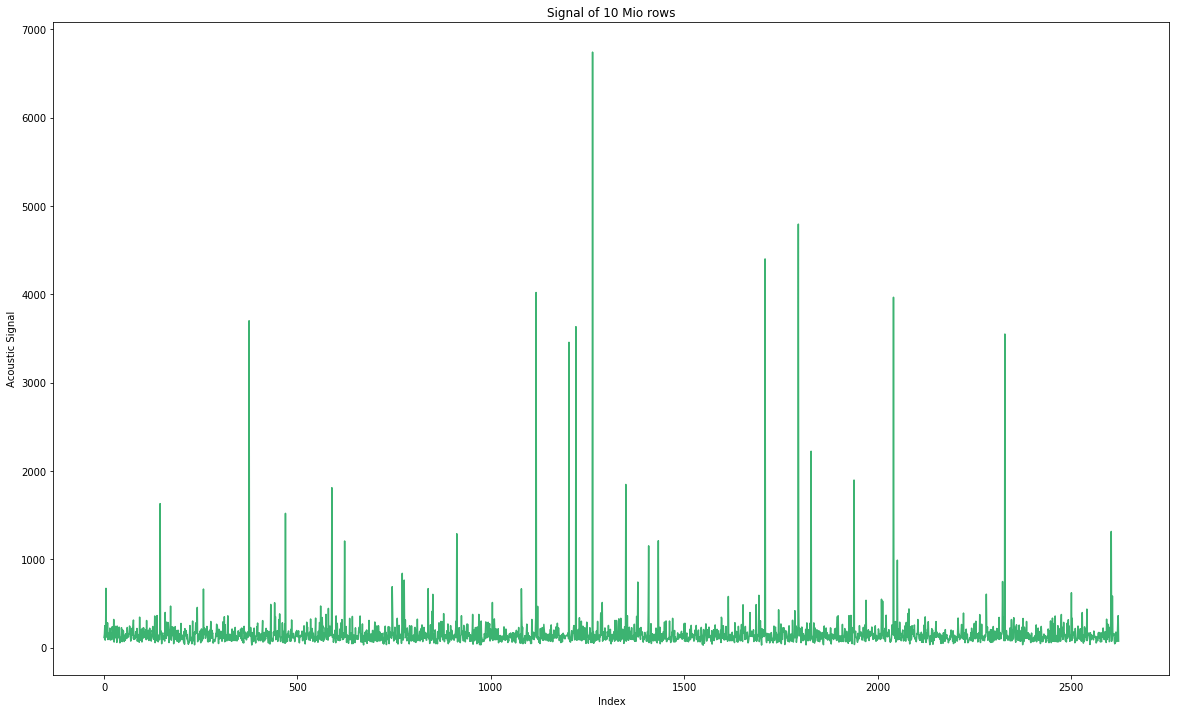

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20,12))
ax.plot(range(len(segs)), segs, c="mediumseagreen")
ax.set_title("Signal of 10 Mio rows")
ax.set_xlabel("Index")
ax.set_ylabel("Acoustic Signal");

As we can see not every segmentation contains a peak over 1000, only around 20 segmentations have such peak.

### Now I have these questions & thoughts:
- 1, What does training data segmentation looks like without peak? Does it have the same feature with test data?
    We saw they are from the same experimental settings but only a few test segments contains peak.
- 2, We already could experimental failure comes after acoustic peak, but what's the relationship none peak part to the failure time? When one experimental earth quake happened what contributes to the time interval the most? 
    - One explanation is the last failure just happend determinds the time interval to next one. Assume the earth quake only released part of the pressure, then how much it released - should be related to how long it takes before next one comes.
    - Another explanation is that some other factor contributes to the time interval, which will reflect in the segmentation acoustic_data without peak. If the acoustic_data couldn't give us the clue, then we cannot predict. But this problem should be predictable.
    For some approach we devide the training data into segments, and apply a sliding window to extract the features of each segments. We could use mean, variance, max and min of the segment to reconstruct the features for input.

## Update
I also considered to transfer the acoustic signal into melspectrogram and use CNN to learn. But found another one who had tried this approach: https://www.kaggle.com/michael422/spectrogram-convolution
They got a fair result so I decide to give up this way.

## Neural Network Approach

Before I consider feature engineering, I tried to learn the data with GRU neural network.
Because the input and output is one dimensional time series, and our goal is regression, I considered to train a GRU to predict y sequence has the same length with input X.<br>
The code is in GRU.py implemented with pytorch, here is my explanation

In [ ]:
# the dimension of input X, I tried only with oroginal acoustic signal
# For future this could extend to mean/variance/etc features of former period
feature_size = 1
batch_size = 64
# this is the length in time dimension of input X, 128 sample points I used
seq_length = 128
# hidden size of GRU
hidden_size = 64
# the sliding window stride of input, if an input starts at X[i] the next input sequence
# starts at X[i + step_length] and the len(input) == seq_length
step_length = 32


class LANLDataset(Dataset):

    # Apply sliding window to the dataset, each input window size is seq_len and stride with a step length
    def __init__(self, pd, seq_len, step_length):
        super(LANLDataset, self).__init__()
        self.pd = pd
        self.X = pd.acoustic_data.values
        self.y = pd.time_to_failure.values
        self.seq_len = seq_len
        self.step_length = step_length

    def __len__(self):
        return int((len(self.pd) - self.seq_len + 1) / self.step_length)

    def __getitem__(self, index):
        # The output is the y of the same time period
        return self.X[index * self.step_length : index * self.step_length + self.seq_len], \
            self.y[index * self.step_length : index * self.step_length + self.seq_len]


In [ ]:
# Network implementation, GRU + 2 * Dense
class GRUNet(nn.Module):

    def __init__(self, batch_size, feature_size, hidden_size, seq_len):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(
            input_size = feature_size,
            hidden_size = hidden_size,
            batch_first = True,
            bidirectional = False,
        )
        self.batch_size = batch_size
        self.feature_size = feature_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.fc1 = nn.Linear(hidden_size, 16 * seq_len)
        self.fc2 = nn.Linear(16 * seq_len, seq_len)

    def forward(self, x):
        x = x.contiguous().view(self.batch_size, self.seq_len, self.feature_size)
        x, _ = self.gru(x)
        x = x[:, :, -1]
        x = x.contiguous().view(self.batch_size, self.seq_len * self.feature_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

### Unfortunately I could have finished the training of the network. Because input is so huge and I lack resource of GPUs

So I turned to feature engineering and refered to some of the kernels in kaggle

First I tried with mean/variance/min/max feature of the input sliding window

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import scipy.stats
from tqdm import tqdm_notebook

import os


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [3]:
# This is a index where first failure occured, used to split a validation set
sec_to_fail = 50085877
test = train.iloc[:sec_to_fail, :]
train = train.iloc[sec_to_fail:, :]

In [6]:
print(len(train))
print(len(test))

579059603
50085877


In [16]:
train

,acoustic_data,time_to_failure
50085877,8,0.000695
50085878,1,14.180600
50085879,2,14.180600
50085880,-1,14.180600
50085881,5,14.180600
50085882,7,14.180600
50085883,4,14.180600
50085884,5,14.180600
50085885,1,14.180600
50085886,-1,14.180600


In [4]:
from librosa.feature import mfcc
from sklearn.decomposition import PCA

fs = 4000000 # Hz
window_time = 0.0375 # seconds
offset = 0.01 # seconds
window_size = int(window_time*fs)

In [8]:
# Very common feature set
def extract_feature(dataset, length):
    feat_mat = np.zeros((length, 5))

    for i in tqdm_notebook(np.arange(0,feat_mat.shape[0])):
        start = int(i*offset*fs)
        stop = int(window_size+i*offset*fs)
        seg = dataset.iloc[start:stop,0]

        feat_mat[i,0] = np.mean(seg)
        feat_mat[i,1] = np.var(seg)
        feat_mat[i,2] = np.max(seg)
        feat_mat[i,3] = np.min(seg)
        feat_mat[i,-1] = dataset.iloc[stop+1,1]

    return feat_mat

In [9]:
%%time

feat_mat = extract_feature(train, 13500)


CPU times: user 8min 3s, sys: 496 ms, total: 8min 4s
Wall time: 32.3 s


In [10]:
test_feat_mat = extract_feature(test, 1100)

In [11]:
df = pd.DataFrame(feat_mat,dtype=np.float64)
test_df = pd.DataFrame(test_feat_mat,dtype=np.float64)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression

In [13]:
dataset = df.values

In [14]:
test_set = test_df.values

In [17]:
# like orginal paper we use Random Forest with 1000 trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(dataset[:,:-1], dataset[:,-1])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [12]:
def eval_result(dataset_, pred):
    res = pred(dataset_[:,:-1])
    plt.plot(res,label='predictions')
    plt.plot(dataset_[:,-1],label='actual')
    plt.legend()

    print("R^2 = ",r2_score(dataset_[:,-1],res))
    print("MAE = ",mean_absolute_error(dataset_[:,-1],res))

R^2 =  0.9361722356483779
MAE =  0.7064312189031826


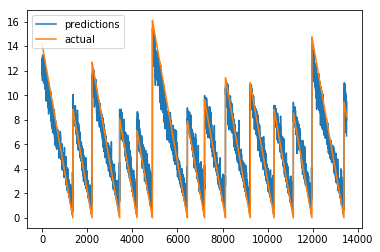

In [41]:
eval_result(dataset, rf.predict)

R^2 =  0.3736277119960686
MAE =  2.0732767988120897


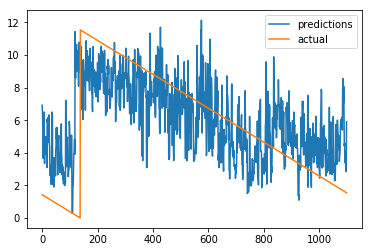

In [44]:
eval_result(test_set, rf.predict)

We can also try Gradient Boost with XGBoost

In [10]:
import xgboost as xgb
xgr = xgb.XGBRegressor(booster='gbtree', n_estimators=100, max_depth=4, n_jobs=72, learning_rate=0.1)


In [133]:
xgr.fit(dataset[:,:-1], dataset[:,-1])

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=72,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

R^2 =  0.460509079359693
MAE =  2.1427964755054285


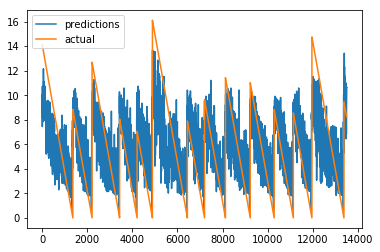

In [134]:
eval_result(dataset, xgr.predict)

R^2 =  0.4516219088378751
MAE =  1.9503378868754953


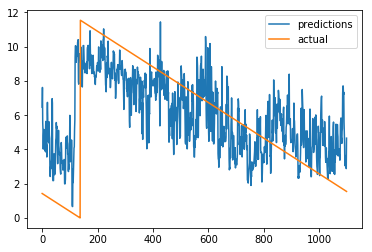

In [135]:
eval_result(test_set, xgr.predict)

Not much gain from tuning parameters, so this should be the limit of current feature set.

Another idea I got is to still treat acoustic signal as sound data and extract melspectrogram features and see if could help

In [145]:
from librosa.feature import mfcc

def extract_feature(dataset, length):
    feat_mat = np.zeros((length, 25))

    for i in tqdm_notebook(np.arange(0,feat_mat.shape[0])):
        start = int(i*offset*fs)
        stop = int(window_size+i*offset*fs)
        seg = dataset.iloc[start:stop,0]

        feat_mat[i,0] = np.mean(seg)
        feat_mat[i,1] = np.var(seg)
        feat_mat[i,2] = np.max(seg)
        feat_mat[i,3] = np.min(seg)
        # From here I added mfcc features
        mfcc_f = mfcc(y=np.array(seg, dtype=np.float32), n_mfcc=10)
        # For each of 10 mfcc features I extracted mean and variance
        for j in range(mfcc_f.shape[0]):
            feat_mat[i, 4 + 2*j] = np.mean(mfcc_f[j])
            feat_mat[i, 4 + 2*j + 1] = np.var(mfcc_f[j])
        feat_mat[i,-1] = dataset.iloc[stop+1,1]

    return feat_mat

In [146]:
feat_mat = extract_feature(train, 13500)

In [147]:
test_feat_mat = extract_feature(test, 1100)

In [148]:
df = pd.DataFrame(feat_mat,dtype=np.float64)
test_df = pd.DataFrame(test_feat_mat,dtype=np.float64)

In [149]:
dataset = df.values
test_set = test_df.values

In [150]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, n_job=72)
rf.fit(dataset[:,:-1], dataset[:,-1])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

R^2 =  0.9431802863746656
MAE =  0.6902663292775622


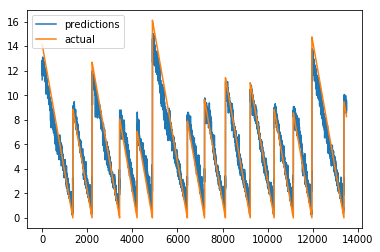

In [151]:
eval_result(dataset, rf.predict)

R^2 =  0.5835190694997232
MAE =  1.728173628973328


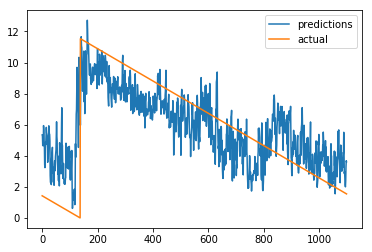

In [152]:
eval_result(test_set, rf.predict)

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


R^2 =  0.9431802863746656
MAE =  0.6902663292775622


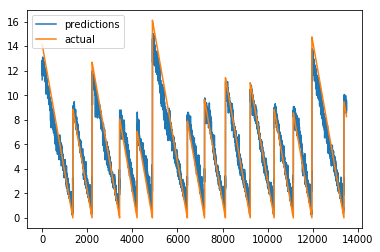

In [153]:
xgr = xgb.XGBRegressor(booster='gbtree', n_estimators=100, max_depth=4, n_jobs=72, learning_rate=0.1)
xgr.fit(dataset[:,:-1], dataset[:,-1])
eval_result(dataset, xgr.predict)

R^2 =  0.5835190694997232
MAE =  1.728173628973328


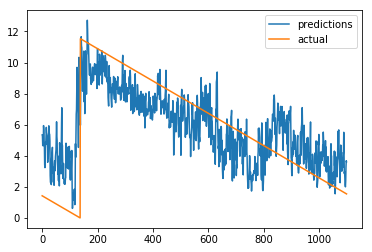

In [154]:
eval_result(test_set, rf.predict)

We could see an improve from the raw feature of mean/variance/min/max setting.<br>
We could further add more features

In [5]:
from librosa.feature import mfcc

def extract_feature(dataset, length):
    feat_mat = np.zeros((length, 85))

    for i in tqdm_notebook(np.arange(0,feat_mat.shape[0])):
        start = int(i*offset*fs)
        stop = int(window_size+i*offset*fs)
        seg = dataset.iloc[start:stop,0]

        feat_mat[i,0] = np.mean(seg)
        feat_mat[i,1] = np.var(seg)
        feat_mat[i,2] = np.max(seg)
        feat_mat[i,3] = np.min(seg)
        # From here I added mfcc features
        mfcc_f = mfcc(y=np.array(seg, dtype=np.float32), n_mfcc=20)
        # For each of 10 mfcc features I extracted mean and variance
        for j in range(mfcc_f.shape[0]):
            feat_mat[i, 4 + 4*j] = np.mean(mfcc_f[j])
            feat_mat[i, 4 + 4*j + 1] = np.var(mfcc_f[j])
            feat_mat[i, 4 + 4*j + 2] = np.max(mfcc_f[j])
            feat_mat[i, 4 + 4*j + 3] = np.min(mfcc_f[j])
        feat_mat[i,-1] = dataset.iloc[stop+1,1]

    return feat_mat

In [6]:
feat_mat = extract_feature(train, 13500)

In [7]:
test_feat_mat = extract_feature(test, 1100)

In [8]:
df = pd.DataFrame(feat_mat,dtype=np.float64)
test_df = pd.DataFrame(test_feat_mat,dtype=np.float64)
dataset = df.values
test_set = test_df.values

R^2 =  0.9493058212195213
MAE =  0.6559102891216156


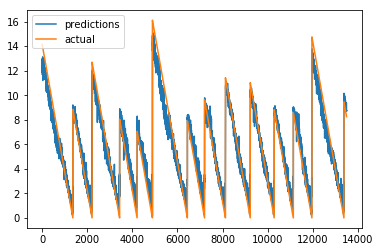

In [161]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, n_jobs=72)
rf.fit(dataset[:,:-1], dataset[:,-1])
eval_result(dataset, rf.predict)

R^2 =  0.5994801956427831
MAE =  1.6856460052605398


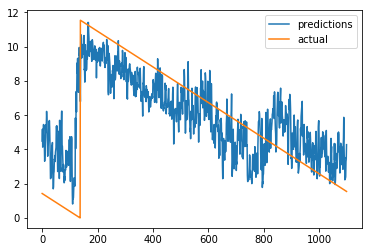

In [162]:
eval_result(test_set, rf.predict)

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


R^2 =  0.6335016387562165
MAE =  1.7940751205506558


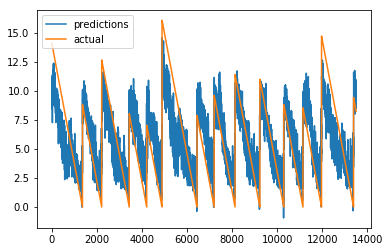

In [15]:
xgr = xgb.XGBRegressor(booster='gbtree', n_estimators=100, max_depth=4, n_jobs=72, learning_rate=0.1)
xgr.fit(dataset[:,:-1], dataset[:,-1])
eval_result(dataset, xgr.predict)

R^2 =  0.5985972098346568
MAE =  1.6611551101751287


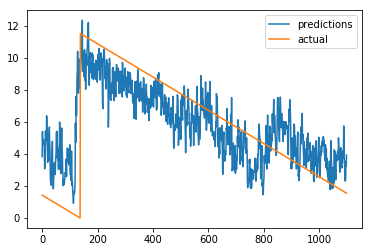

In [16]:
eval_result(test_set, xgr.predict)

## Finally I tried to ensemble two models but only got average result

In [186]:
pred_rf = rf.predict(dataset[:,:-1])
pred_xgr = xgr.predict(dataset[:,:-1])

preds = np.zeros((pred_rf.shape[0],2))

preds[:,0:1] = pred_rf.reshape(-1,1)
preds[:,1:2] = pred_xgr.reshape(-1,1)


In [187]:
ds_ens = np.concatenate((dataset[:,:-1],preds),axis=1)
ds_ens.shape

(13500, 86)

In [188]:
rf_ens = RandomForestRegressor(n_estimators = 1000, random_state = 42, n_jobs=72)

# Train the model on training data
rf_ens.fit(ds_ens, dataset[:,-1])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=72,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

R^2 =  0.5792328603044525
MAE =  1.7181738847046042


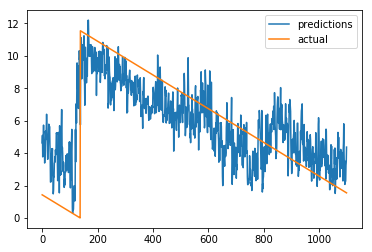

In [190]:
pred_rf = rf.predict(test_set[:,:-1])
pred_xgr = xgr.predict(test_set[:,:-1])

preds = np.zeros((pred_rf.shape[0],2))

preds[:,0:1] = pred_rf.reshape(-1,1)
preds[:,1:2] = pred_xgr.reshape(-1,1)

test_ens = np.concatenate((test_set[:,:-1],preds),axis=1)

pred_rf_ens = rf_ens.predict(test_ens)

plt.plot(pred_rf_ens,label='predictions')
plt.plot(test_set[:,-1],label='actual')
plt.legend()

print("R^2 = ",r2_score(test_set[:,-1],pred_rf_ens))
print("MAE = ",mean_absolute_error(test_set[:,-1],pred_rf_ens))

If I have more time I will try other methods like 1-conv neural network, 

In [20]:
from tqdm import tqdm_notebook

submission = pd.read_csv('sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})
X_test = pd.DataFrame(columns=df.columns, dtype=np.float64, index=submission.index)

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('./test/' + seg_id + '.csv')
    X_test.loc[seg_id, 0] = np.mean(seg.values)
    X_test.loc[seg_id, 1] = np.var(seg.values)
    X_test.loc[seg_id, 2] = np.max(seg.values)
    X_test.loc[seg_id, 3] = np.min(seg.values)
    mfcc_f = mfcc(y=np.array(seg, dtype=np.float32).flatten(), n_mfcc=20)
    # For each of 10 mfcc features I extracted mean and variance
    for j in range(mfcc_f.shape[0]):
        X_test.loc[seg_id, 4 + 4*j] = np.mean(mfcc_f[j])
        X_test.loc[seg_id, 4 + 4*j + 1] = np.var(mfcc_f[j])
        X_test.loc[seg_id, 4 + 4*j + 2] = np.max(mfcc_f[j])
        X_test.loc[seg_id, 4 + 4*j + 3] = np.min(mfcc_f[j])

In [22]:
X_test.drop(columns=[84],inplace=True)

In [23]:
pred = xgr.predict(X_test.values)

submission['time_to_failure'] = pred
submission.to_csv('submission.csv')

In [24]:
submission

,time_to_failure
seg_id,
seg_00030f,4.012578
seg_0012b5,6.122934
seg_00184e,6.372355
seg_003339,8.763474
seg_0042cc,8.006273
seg_004314,2.419567
seg_004cd2,7.406033
seg_004ee5,5.698885
seg_004f1f,5.404786


### To conclude:
I used XGBoost to get current best performance on a self-constructed feature series. Including mean/var/max/min and mfcc features, further adding features might improve performance. Also data augumentation should be considered but I dont have time to implement.
For future:
    - data augumentation
    - small sliding window
    - Seq2seq prediction
    - more ensemble